In [1]:
using Gurobi
using QPSReader
using QuadraticModels
using NLPModels
using SolverTools
using SolverBenchmark
using DataFrames
using BenchmarkTools
using LinearAlgebra
using Plots
using SparseArrays

┌ Info: Precompiling Gurobi [2e9cd046-0924-5485-92f1-d5272153d98b]
└ @ Base loading.jl:1278


In [2]:
show_statuses()

STATUSES:
  :acceptable     => solved to within acceptable tolerances
  :exception      => unhandled exception
  :first_order    => first-order stationary
  :infeasible     => problem may be infeasible
  :max_eval       => maximum number of function evaluations
  :max_iter       => maximum iteration
  :max_time       => maximum elapsed time
  :neg_pred       => negative predicted reduction
  :not_desc       => not a descent direction
  :small_residual => small residual
  :small_step     => step too small
  :stalled        => stalled
  :unbounded      => objective function may be unbounded from below
  :unknown        => unknown
  :user           => user-requested stop


default stopping criteria \
barrier maxiter: default 1000 \
relative difference between the primal and dual objective : 1e-8 (1e-6 for QCP) \
primal feas tolerance: all constraints smaller than 1e-6 \
reduced costs all smaller than 1e-6 \

\



Sets a limit on the amount of diagonal perturbation that the optimizer is allowed  
to perform on a Q matrix in order to correct minor PSD violations.
If a larger perturbation is required, the optimizer will terminate with a GRB_ERROR_Q_NOT_PSD error. \
default 1e-6


standard gurobi form\
    min f'x , Aeqx=beq, Ax>=b, l<x<u  


In [3]:
##################################################################
####################### INFO ATTRIBUTES #########################
# https://www.gurobi.com/documentation/9.0/refman/attributes.html 

function createQuadraticModel(qpdata)
    # probleme du point initial
    #x0 = init_x0(qpdata.lvar, qpdata.uvar)
    return QuadraticModel(qpdata.c, qpdata.qrows, qpdata.qcols, qpdata.qvals,
                        Arows=qpdata.arows, Acols=qpdata.acols, Avals=qpdata.avals, 
                        lcon=qpdata.lcon, ucon=qpdata.ucon, lvar=qpdata.lvar, uvar=qpdata.uvar,
                        c0=qpdata.c0)

end

    

function optimizeGurobi(QM)
    SM = SlackModel(QM)
    #SM = QM
    env = Gurobi.Env()
    
    # -1=automatic, 0=primal simplex, 1=dual simplex, 2=barrier, 
    # 3=concurrent, 4=deterministic concurrent, 5=deterministic concurrent simplex.
    setparam!(env, "Method", 2)
    
    # set presolve to 0
    setparam!(env, "Presolve", 0)
    
    # no scaling
    setparam!(env, "ScaleFlag", 0)
    
    setparam!(env, "Crossover", 0)
    
    #setparam!(env, "BarIterLimit", 1000)
    
    Aeq = jac(SM, SM.meta.x0)
    beq = SM.meta.lcon
    f = grad(SM, zeros(length(SM.meta.x0)))
    H = hess(SM, zeros(length(SM.meta.x0)))
    H = Matrix(Symmetric(H, :L))
    n,m = size(Aeq)
    model = gurobi_model(env; f = f, H = H,
                        Aeq = Aeq, beq = beq,
                        lb = SM.meta.lvar, ub = SM.meta.uvar)
     # run optimization
    optimize(model)

    # y with dual: b'*y   s.t. A'*y <= c and y >= 0
    y = zeros(n)
    for i=1:n
        y[i] = Gurobi.get_dblattrelement(model, "Pi", i)
    end

    s = zeros(m) # s_l - s_u
    for i=1:m
        s[i] = Gurobi.get_dblattrelement(model, "RC", i)
    end

    # outputs
    optim_info = get_optiminfo(model)
    if optim_info.status == :optimal
        status = :acceptable
    elseif optim_info.status == :iteration_limit
        status = :max_iter
    elseif optim_info.status == :unbounded
        status = :unbounded
    else
        status = :unknown
    end

    x = get_solution(model)
    println("####################")
    println(Gurobi.get_dblattr(model, "ConstrResidual"))
    println(Gurobi.get_dblattr(model, "DualResidual"))
    stats = GenericExecutionStats(status, SM, solution = x,
                                  objective = get_objval(model),
                                  iter = Gurobi.get_intattr(model,"BarIterCount"),
                                  primal_feas = norm(Aeq * x - beq),
                                  dual_feas = norm(Aeq' * y - H*x + s - f),
                                  solver_specific = Dict(:multipliers => y),
                                  elapsed_time = optim_info.runtime)
    return stats
end


function optimizeGurobi(qpdata::QPSData)
    return optimizeGurobi(createQuadraticModel(qpdata))
end



optimizeGurobi (generic function with 2 methods)

In [4]:
path_pb = "C:\\Users\\Geoffroy Leconte\\Documents\\cours\\TFE\\code\\problemes_marosmeszaros"
pb2 = string(path_pb, "\\DUAL1.SIF")
qpdata2 = readqps(pb2);
#qpdata2 = readqps(pb2,mpsformat=:fixed);

┌ Info: Using 'DUAL1' as NAME (l. 1)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:751
┌ Info: Using 'OBJ.FUNC' as objective (l. 17)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:350
┌ Info: Using 'RHS' as RHS (l. 106)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:470
┌ Info: Using 'BOUNDS' as BOUNDS (l. 109)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:622


In [5]:
stats2 = optimizeGurobi(qpdata2)
println(stats2)

ErrorException: Invalid Gurobi license

In [6]:
# problem 3   kb2    obj  -1.7499001299E+03
kb2 = string(path_pb, "\\KB2.SIF")
qpdata3 = readqps(kb2)
stats3 =  optimizeGurobi(qpdata3)
println(stats3)

┌ Info: Using 'KB2' as NAME (l. 5)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:751
┌ Info: Using 'FAT7..J.' as objective (l. 20)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:350
┌ Info: Using '77BOUND' as BOUNDS (l. 227)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:622


ErrorException: Invalid Gurobi license

In [12]:
# problem 3   
pb4 = string(path_pb, "\\EXDATA.SIF")
qpdata4 = readqps(pb4, mpsformat=:fixed)
stats4 =  optimizeGurobi(qpdata4)
#println(stats4)

┌ Info: Using 'EXDATA' as NAME (l. 1)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:751
┌ Info: Using 'obj' as objective (l. 3018)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:350
┌ Info: Using 'rhs' as RHS (l. 9021)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:470
┌ Info: Using '' as BOUNDS (l. 9023)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:622


ErrorException: Invalid Gurobi license

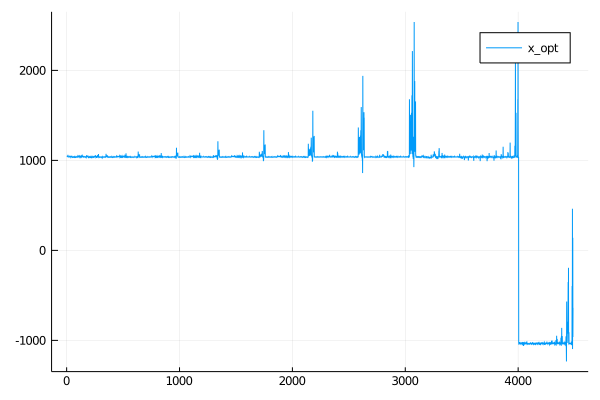

In [17]:
plot(stats4[1].solution, label="x_opt")

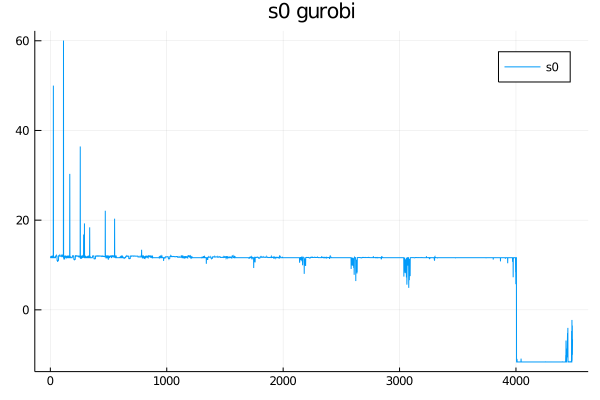

In [18]:
plot(stats4[2], label="s0")
title!("s0 gurobi")

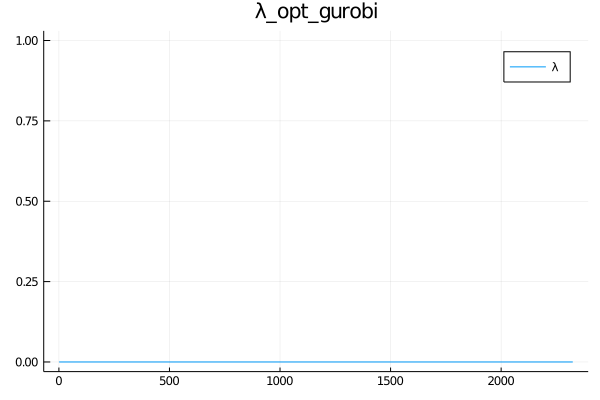

In [19]:
gr()
plot(stats4[1].multipliers, label="λ")
title!("λ_opt_gurobi")

# Test sur tous les pb

In [22]:
df_test = DataFrame(id = Int[],
         name = String[],
         status = Symbol[],
         objective = Float64[],
         time = Float64[],
         iter = Int[],
         primal_feas = Float64[],
         dual_feas = Float64[])


i = 0
for file_name in readdir(path_pb)
    if file_name[end-3:end] == ".SIF" && !(file_name in ["80BAU3B.SIF" ; "BORE3D.SIF"; 
                                                        "CAPRI.SIF"; "CZPROB.SIF"; 
                                                        "ETAMACRO.SIF"; "FINNIS.SIF";
                                                        "FORPLAN.SIF"; "GREENBEA.SIF";
                                                        "GREENBEB.SIF"; "MAROS.SIF";
                                                        "NESM.SIF"; "PEROLD.SIF";
                                                         "PILOT-JA.SIF"; "PILOT-WE.SIF";
                                                         "PILOT.SIF"; "PILOT4.SIF";
                                                         "PILOT87.SIF"; "PILOTNOV.SIF";
                                                          "RECIPELP.SIF"; "SHELL.SIF";
                                                         "SIERRA.SIF"; "STAIR.SIF";
                                                         "STANDATA.SIF"; "STANDGUB.SIF";
                                                        "STANDMPS.SIF"; "TUFF.SIF";
                                                        "VTP-BASE.SIF"; "DTOC3.SIF";
                                                         "HS35MOD.SIF";"QBORE3D.SIF";
                                                        "QCAPRI.SIF"; "QETAMACR.SIF";
                                                          "QFORPLAN.SIF"; "QPCSTAIR.SIF";
                                                        "QPCSTAIR.SIF"; "QPILOTNO.SIF";
                                                        "QRECIPE.SIF"; "QSHELL.SIF";
                                                        "QSIERRA.SIF"; "QSTAIR.SIF";
                                                        "QSTANDAT.SIF"; "UBH1.SIF"; 
                                                        "YAO.SIF"]) # problems with fixed variables
        
        i += 1
        println(file_name)
        pb_i = string(path_pb, "\\", file_name)
        if file_name in ["BLEND.SIF"; "DFL001.SIF"; "FORPLAN.SIF"; "GFRD-PNC.SIF"; "SIERRA.SIF";
                        "EXDATA.SIF"; "QFORPLAN.SIF"; "QGFRDXPN.SIF"; "VALUES.SIF"]
            qpdata_i = readqps(pb_i, mpsformat=:fixed) 
        else
            qpdata_i = readqps(pb_i) 
        end
        SM_i = SlackModel(createQuadraticModel(qpdata_i))
        if SM_i.meta.ifix != []
            println("problem fixed variables ", SM_i.meta.ifix, "   ", file_name)
        end
        #stats_i = optimizeGurobi(qpdata_i)
        
#         push!(df_test, Dict(:id => i,
#                 :name => file_name[1:end-4] ,
#                              :status => stats_i.status,
#                              :objective => stats_i.objective,
#                              :time => stats_i.elapsed_time,
#                              :iter => stats_i.iter,
#                              :primal_feas => stats_i.primal_feas,
#                              :dual_feas => stats_i.dual_feas))

    end
    if i == 1000
        break
        break
    end
end

AUG2D.SIF


┌ Info: Using 'AUG2D' as NAME (l. 1)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:751


AUG2DC.SIF


┌ Info: Using 'OBJ.FUNC' as objective (l. 17)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:350
┌ Info: Using 'RHS' as RHS (l. 50020)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:470
┌ Info: Using 'BOUNDS' as BOUNDS (l. 60023)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:622
┌ Info: Using 'AUG2DC' as NAME (l. 1)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:751
┌ Info: Using 'OBJ.FUNC' as objective (l. 17)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:350
┌ Info: Using 'RHS' as RHS (l. 50020)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:470


AUG2DCQP.SIF


┌ Info: Using 'BOUNDS' as BOUNDS (l. 60023)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:622
┌ Info: Using 'AUG2DCQP' as NAME (l. 1)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:751


AUG2DQP.SIF


┌ Info: Using 'OBJ.FUNC' as objective (l. 17)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:350
┌ Info: Using 'RHS' as RHS (l. 50020)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:470
┌ Info: Using 'BOUNDS' as BOUNDS (l. 60023)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:622
┌ Info: Using 'AUG2DQP' as NAME (l. 1)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:751


AUG3D.SIF


┌ Info: Using 'OBJ.FUNC' as objective (l. 17)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:350
┌ Info: Using 'RHS' as RHS (l. 50020)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:470
┌ Info: Using 'BOUNDS' as BOUNDS (l. 60023)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:622
┌ Info: Using 'AUG3D' as NAME (l. 1)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:751
┌ Info: Using 'OBJ.FUNC' as objective (l. 17)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:350
┌ Info: Using 'RHS' as RHS (l. 7566)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:470


AUG3DC.SIF
AUG3DCQP.SIF
AUG3DQP.SIF
BOYD1.SIF


┌ Info: Using 'BOUNDS' as BOUNDS (l. 8569)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:622
┌ Info: Using 'AUG3DC' as NAME (l. 1)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:751
┌ Info: Using 'OBJ.FUNC' as objective (l. 17)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:350
┌ Info: Using 'RHS' as RHS (l. 7566)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:470
┌ Info: Using 'BOUNDS' as BOUNDS (l. 8569)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:622
┌ Info: Using 'AUG3DCQP' as NAME (l. 1)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:751
┌ Info: Using 'OBJ.FUNC' as objective (l. 17)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:350
┌ Info: Using 'RHS' as RHS (l. 7566)
└ @ QPSReader C:\Users\Geoffroy L

BOYD2.SIF


┌ Info: Using 'BOUNDS' as BOUNDS (l. 486237)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:622
┌ Info: Using 'BOYD2' as NAME (l. 1)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:751
┌ Info: Using 'OBJ.FUNC' as objective (l. 17)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:350
┌ Info: Using 'RHS' as RHS (l. 403940)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:470


CONT-050.SIF
CONT-100.SIF


┌ Info: Using 'BOUNDS' as BOUNDS (l. 403951)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:622
┌ Info: Using 'CONT-050' as NAME (l. 1)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:751
┌ Info: Using 'OBJ.FUNC' as objective (l. 17)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:350
┌ Info: Using 'RHS' as RHS (l. 9816)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:470
┌ Info: Using 'BOUNDS' as BOUNDS (l. 12219)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:622
┌ Info: Using 'CONT1-100' as NAME (l. 1)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:751
┌ Info: Using 'OBJ.FUNC' as objective (l. 17)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:350
┌ Info: Using 'RHS' as RHS (l. 39616)
└ @ QPSReader C:\Users\Geo

CONT-101.SIF


┌ Info: Using 'CONT-101' as NAME (l. 1)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:751
┌ Info: Using 'OBJ.FUNC' as objective (l. 17)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:350


CONT-200.SIF


┌ Info: Using 'RHS' as RHS (l. 39818)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:470
┌ Info: Using 'BOUNDS' as BOUNDS (l. 40018)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:622
┌ Info: Using 'CONT1-200' as NAME (l. 1)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:751
┌ Info: Using 'OBJ.FUNC' as objective (l. 17)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:350
┌ Info: Using 'RHS' as RHS (l. 159216)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:470
┌ Info: Using 'BOUNDS' as BOUNDS (l. 198819)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:622


CONT-201.SIF


┌ Info: Using 'CONT-201' as NAME (l. 1)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:751
┌ Info: Using 'OBJ.FUNC' as objective (l. 17)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:350
┌ Info: Using 'RHS' as RHS (l. 159618)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:470
┌ Info: Using 'BOUNDS' as BOUNDS (l. 160018)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:622


CONT-300.SIF


┌ Info: Using 'CONT-300' as NAME (l. 1)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:751
┌ Info: Using 'OBJ.FUNC' as objective (l. 17)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:350
┌ Info: Using 'RHS' as RHS (l. 359418)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:470


CVXQP1_L.SIF


┌ Info: Using 'BOUNDS' as BOUNDS (l. 360018)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:622
┌ Info: Using 'CVXQP1_L' as NAME (l. 1)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:751
┌ Info: Using 'OBJ.FUNC' as objective (l. 17)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:350
┌ Info: Using 'RHS' as RHS (l. 17520)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:470


CVXQP1_M.SIF
CVXQP1_S.SIF
CVXQP2_L.SIF


┌ Info: Using 'BOUNDS' as BOUNDS (l. 22522)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:622
┌ Info: Using 'CVXQP1_M' as NAME (l. 1)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:751
┌ Info: Using 'OBJ.FUNC' as objective (l. 17)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:350
┌ Info: Using 'RHS' as RHS (l. 1770)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:470
┌ Info: Using 'BOUNDS' as BOUNDS (l. 2272)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:622
┌ Info: Using 'CVXQP1_S' as NAME (l. 1)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:751
┌ Info: Using 'OBJ.FUNC' as objective (l. 17)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:350
┌ Info: Using 'RHS' as RHS (l. 195)
└ @ QPSReader C:\Users\Geoffroy

CVXQP2_M.SIF
CVXQP2_S.SIF
CVXQP3_L.SIF


┌ Info: Using 'BOUNDS' as BOUNDS (l. 15522)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:622
┌ Info: Using 'CVXQP2_M' as NAME (l. 1)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:751
┌ Info: Using 'OBJ.FUNC' as objective (l. 17)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:350
┌ Info: Using 'RHS' as RHS (l. 1319)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:470
┌ Info: Using 'BOUNDS' as BOUNDS (l. 1571)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:622
┌ Info: Using 'CVXQP2_S' as NAME (l. 1)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:751
┌ Info: Using 'OBJ.FUNC' as objective (l. 17)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:350
┌ Info: Using 'RHS' as RHS (l. 149)
└ @ QPSReader C:\Users\Geoffroy

CVXQP3_M.SIF
CVXQP3_S.SIF
DPKLO1.SIF
DUAL1.SIF
DUAL2.SIF
DUAL3.SIF


┌ Info: Using 'CVXQP3_M' as NAME (l. 1)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:751
┌ Info: Using 'OBJ.FUNC' as objective (l. 17)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:350
┌ Info: Using 'RHS' as RHS (l. 2368)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:470
┌ Info: Using 'BOUNDS' as BOUNDS (l. 3120)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:622
┌ Info: Using 'CVXQP3_S' as NAME (l. 1)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:751
┌ Info: Using 'OBJ.FUNC' as objective (l. 17)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:350
┌ Info: Using 'RHS' as RHS (l. 252)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:470
┌ Info: Using 'BOUNDS' as BOUNDS (l. 329)
└ @ QPSReader C:\Users\Geoffroy L

DUAL4.SIF
DUALC1.SIF
DUALC2.SIF
DUALC5.SIF
DUALC8.SIF
EXDATA.SIF


┌ Info: Using 'DUAL4' as NAME (l. 1)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:751
┌ Info: Using 'OBJ.FUNC' as objective (l. 17)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:350
┌ Info: Using 'RHS' as RHS (l. 96)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:470
┌ Info: Using 'BOUNDS' as BOUNDS (l. 99)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:622
┌ Info: Using 'DUALC1' as NAME (l. 1)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:751
┌ Info: Using 'OBJ.FUNC' as objective (l. 17)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:350
┌ Info: Using 'RHS' as RHS (l. 1207)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:470
┌ Info: Using 'BOUNDS' as BOUNDS (l. 1210)
└ @ QPSReader C:\Users\Geoffroy Leconte\

GENHS28.SIF
GOULDQP2.SIF
GOULDQP3.SIF
HS118.SIF
HS21.SIF
HS268.SIF
HS35.SIF
HS51.SIF
HS52.SIF


┌ Info: Using 'GENHS28' as NAME (l. 1)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:751
┌ Info: Using 'OBJ.FUNC' as objective (l. 17)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:350
┌ Info: Using 'RHS' as RHS (l. 44)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:470
┌ Info: Using 'BOUNDS' as BOUNDS (l. 54)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:622
┌ Info: Using 'GOULDQP2' as NAME (l. 1)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:751
┌ Info: Using 'OBJ.FUNC' as objective (l. 17)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:350
┌ Info: Using 'BOUNDS' as BOUNDS (l. 1070)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:622
┌ Info: Using 'GOULDQP3' as NAME (l. 1)
└ @ QPSReader C:\Users\Geoffroy L

HS53.SIF
HS76.SIF
HUES-MOD.SIF


┌ Info: Using 'HS53' as NAME (l. 1)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:751
┌ Info: Using 'OBJ.FUNC' as objective (l. 17)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:350
┌ Info: Using 'RHS' as RHS (l. 30)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:470
┌ Info: Using 'BOUNDS' as BOUNDS (l. 33)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:622
┌ Info: Using 'HS76' as NAME (l. 1)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:751
┌ Info: Using 'OBJ.FUNC' as objective (l. 17)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:350
┌ Info: Using 'RHS' as RHS (l. 31)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:470
┌ Info: Using 'HUES-MOD' as NAME (l. 1)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\p

HUESTIS.SIF
KSIP.SIF


┌ Info: Using 'RHS' as RHS (l. 10022)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:470
┌ Info: Using 'HUESTIS' as NAME (l. 1)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:751
┌ Info: Using 'OBJ.FUNC' as objective (l. 17)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:350
┌ Info: Using 'RHS' as RHS (l. 10022)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:470
┌ Info: Using 'KSIP' as NAME (l. 1)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:751
┌ Info: Using 'OBJ.FUNC' as objective (l. 17)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:350


LASER.SIF
LISWET1.SIF


┌ Info: Using 'RHS' as RHS (l. 10986)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:470
┌ Info: Using 'BOUNDS' as BOUNDS (l. 11988)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:622
┌ Info: Using 'LASER' as NAME (l. 1)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:751
┌ Info: Using 'COST' as objective (l. 17)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:350
┌ Info: Using 'RHS' as RHS (l. 4020)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:470
┌ Info: Using 'RANGE' as RANGES (l. 5021)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:552
┌ Info: Using 'BOUNDS' as BOUNDS (l. 6022)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:622
┌ Info: Using 'LISWET1' as NAME (l. 1)
└ @ QPSReader C:\Users\Geoffroy Leconte\.

LISWET10.SIF


┌ Info: Using 'OBJ.FUNC' as objective (l. 17)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:350
┌ Info: Using 'RHS' as RHS (l. 30022)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:470
┌ Info: Using 'BOUNDS' as BOUNDS (l. 30025)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:622
┌ Info: Using 'LISWET10' as NAME (l. 1)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:751


LISWET11.SIF


┌ Info: Using 'OBJ.FUNC' as objective (l. 17)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:350
┌ Info: Using 'RHS' as RHS (l. 30022)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:470
┌ Info: Using 'BOUNDS' as BOUNDS (l. 30025)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:622
┌ Info: Using 'LISWET11' as NAME (l. 1)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:751


LISWET12.SIF


┌ Info: Using 'OBJ.FUNC' as objective (l. 17)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:350
┌ Info: Using 'RHS' as RHS (l. 30022)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:470
┌ Info: Using 'BOUNDS' as BOUNDS (l. 30025)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:622
┌ Info: Using 'LISWET12' as NAME (l. 1)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:751


LISWET2.SIF


┌ Info: Using 'OBJ.FUNC' as objective (l. 17)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:350
┌ Info: Using 'RHS' as RHS (l. 30022)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:470
┌ Info: Using 'BOUNDS' as BOUNDS (l. 30025)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:622
┌ Info: Using 'LISWET2' as NAME (l. 1)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:751
┌ Info: Using 'OBJ.FUNC' as objective (l. 17)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:350


LISWET3.SIF


┌ Info: Using 'RHS' as RHS (l. 30022)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:470
┌ Info: Using 'BOUNDS' as BOUNDS (l. 30025)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:622
┌ Info: Using 'LISWET3' as NAME (l. 1)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:751


LISWET4.SIF


┌ Info: Using 'OBJ.FUNC' as objective (l. 17)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:350
┌ Info: Using 'RHS' as RHS (l. 30022)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:470
┌ Info: Using 'BOUNDS' as BOUNDS (l. 30025)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:622
┌ Info: Using 'LISWET4' as NAME (l. 1)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:751


LISWET5.SIF


┌ Info: Using 'OBJ.FUNC' as objective (l. 17)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:350
┌ Info: Using 'RHS' as RHS (l. 30022)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:470
┌ Info: Using 'BOUNDS' as BOUNDS (l. 30025)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:622
┌ Info: Using 'LISWET5' as NAME (l. 1)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:751


LISWET6.SIF


┌ Info: Using 'OBJ.FUNC' as objective (l. 17)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:350
┌ Info: Using 'RHS' as RHS (l. 30022)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:470
┌ Info: Using 'BOUNDS' as BOUNDS (l. 30025)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:622
┌ Info: Using 'LISWET6' as NAME (l. 1)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:751


LISWET7.SIF


┌ Info: Using 'OBJ.FUNC' as objective (l. 17)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:350
┌ Info: Using 'RHS' as RHS (l. 30022)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:470
┌ Info: Using 'BOUNDS' as BOUNDS (l. 30025)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:622
┌ Info: Using 'LISWET7' as NAME (l. 1)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:751


LISWET8.SIF


┌ Info: Using 'OBJ.FUNC' as objective (l. 17)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:350
┌ Info: Using 'RHS' as RHS (l. 30022)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:470
┌ Info: Using 'BOUNDS' as BOUNDS (l. 30025)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:622
┌ Info: Using 'LISWET8' as NAME (l. 1)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:751


LISWET9.SIF


┌ Info: Using 'OBJ.FUNC' as objective (l. 17)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:350
┌ Info: Using 'RHS' as RHS (l. 30022)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:470
┌ Info: Using 'BOUNDS' as BOUNDS (l. 30025)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:622
┌ Info: Using 'LISWET9' as NAME (l. 1)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:751


LOTSCHD.SIF
MOSARQP1.SIF
MOSARQP2.SIF
POWELL20.SIF


┌ Info: Using 'OBJ.FUNC' as objective (l. 17)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:350
┌ Info: Using 'RHS' as RHS (l. 30022)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:470
┌ Info: Using 'BOUNDS' as BOUNDS (l. 30025)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:622
┌ Info: Using 'LOTSCHD' as NAME (l. 1)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:751
┌ Info: Using 'OBJ.FUNC' as objective (l. 17)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:350
┌ Info: Using 'RHS' as RHS (l. 55)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:470
┌ Info: Using 'MOSARQP1' as NAME (l. 1)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:751
┌ Info: Using 'OBJ.FUNC' as objective (l. 17)
└ @ QPSReader C:\Users\Geoffr

PRIMAL1.SIF


┌ Info: Using 'OBJ.FUNC' as objective (l. 17)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:350
┌ Info: Using 'RHS' as RHS (l. 20020)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:470
┌ Info: Using 'BOUNDS' as BOUNDS (l. 30022)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:622
┌ Info: Using 'PRIMAL1' as NAME (l. 1)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:751


PRIMAL2.SIF
PRIMAL3.SIF


┌ Info: Using 'OBJ.FUNC' as objective (l. 17)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:350
┌ Info: Using 'RHS' as RHS (l. 3188)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:470
┌ Info: Using 'BOUNDS' as BOUNDS (l. 3274)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:622
┌ Info: Using 'PRIMAL2' as NAME (l. 1)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:751
┌ Info: Using 'OBJ.FUNC' as objective (l. 17)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:350
┌ Info: Using 'RHS' as RHS (l. 4497)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:470
┌ Info: Using 'BOUNDS' as BOUNDS (l. 4594)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:622
┌ Info: Using 'PRIMAL3' as NAME (l. 1)
└ @ QPSReader C:\Users\Geoffroy L

PRIMAL4.SIF
PRIMALC1.SIF
PRIMALC2.SIF
PRIMALC5.SIF
PRIMALC8.SIF
Q25FV47.SIF


┌ Info: Using 'RHS' as RHS (l. 11146)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:470
┌ Info: Using 'BOUNDS' as BOUNDS (l. 11258)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:622
┌ Info: Using 'PRIMAL4' as NAME (l. 1)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:751
┌ Info: Using 'OBJ.FUNC' as objective (l. 17)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:350
┌ Info: Using 'RHS' as RHS (l. 8684)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:470
┌ Info: Using 'BOUNDS' as BOUNDS (l. 8760)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:622
┌ Info: Using 'PRIMALC1' as NAME (l. 1)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:751
┌ Info: Using 'OBJ.FUNC' as objective (l. 17)
└ @ QPSReader C:\Users\Geoffro

QADLITTL.SIF
QAFIRO.SIF
QBANDM.SIF
QBEACONF.SIF
QBRANDY.SIF
QE226.SIF
QFFFFF80.SIF


┌ Info: Using 'QADLITTL' as NAME (l. 1)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:751
┌ Info: Using '.Z....' as objective (l. 17)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:350
┌ Info: Using 'ZZZZ0001' as RHS (l. 330)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:470
┌ Info: Using 'QAFIRO' as NAME (l. 1)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:751
┌ Info: Using 'COST' as objective (l. 44)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:350
┌ Info: Using 'B' as RHS (l. 93)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:470
┌ Info: Using 'QBANDM' as NAME (l. 1)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:751
┌ Info: Using '....1' as objective (l. 17)
└ @ QPSReader C:\Users\Geoffroy Leconte\.jul

QGFRDXPN.SIF
QGROW15.SIF
QGROW22.SIF
QGROW7.SIF
QISRAEL.SIF


┌ Info: Using 'QGFRDXPN' as NAME (l. 1)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:751
┌ Info: Using 'OBJ' as objective (l. 17)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:350
┌ Info: Using '' as RHS (l. 2818)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:470
┌ Info: Using '' as BOUNDS (l. 2853)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:622
┌ Info: Using 'QGROW15' as NAME (l. 1)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:751
┌ Info: Using 'REVENUE' as objective (l. 16)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:350
┌ Info: Using 'RHS' as RHS (l. 3259)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:470
┌ Info: Using 'YSBOUND' as BOUNDS (l. 3261)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia

QPCBLEND.SIF
QPCBOEI1.SIF
QPCBOEI2.SIF
QPTEST.SIF
QSC205.SIF
QSCAGR25.SIF
QSCAGR7.SIF
QSCFXM1.SIF
QSCFXM2.SIF


┌ Info: Using 'RHS1' as RHS (l. 1418)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:470
┌ Info: Using 'QPCBLEND' as NAME (l. 1)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:751
┌ Info: Using 'OBJ.FUNC' as objective (l. 17)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:350
┌ Info: Using 'RHS' as RHS (l. 369)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:470
┌ Info: Using 'QPCBOEI1' as NAME (l. 1)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:751
┌ Info: Using 'OBJ.FUNC' as objective (l. 17)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:350
┌ Info: Using 'RHS' as RHS (l. 2368)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:470
┌ Info: Using 'RANGES' as RANGES (l. 2486)
└ @ QPSReader C:\Users\Geoffroy Lecon

QSCFXM3.SIF
QSCORPIO.SIF
QSCRS8.SIF
QSCSD1.SIF
QSCSD6.SIF


┌ Info: Using 'QSCFXM3' as NAME (l. 1)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:751
┌ Info: Using '.COSTA' as objective (l. 17)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:350
┌ Info: Using 'ZZZZ0001' as RHS (l. 5301)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:470
┌ Info: Using 'QSCORPIO' as NAME (l. 1)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:751
┌ Info: Using 'C9999' as objective (l. 17)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:350
┌ Info: Using 'SM' as RHS (l. 1349)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:470
┌ Info: Using 'QSCRS8' as NAME (l. 1)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:751
┌ Info: Using 'COST' as objective (l. 17)
└ @ QPSReader C:\Users\Geoffroy Leconte

QSCSD8.SIF
QSCTAP1.SIF


┌ Info: Using '50000000' as objective (l. 17)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:350
┌ Info: Using 'RHS' as RHS (l. 3659)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:470
┌ Info: Using 'QSCSD8' as NAME (l. 1)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:751
┌ Info: Using '50000000' as objective (l. 17)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:350
┌ Info: Using 'rhs' as RHS (l. 11751)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:470
┌ Info: Using 'QSCTAP1' as NAME (l. 1)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:751


QSCTAP2.SIF
QSCTAP3.SIF


┌ Info: Using 'OBJZZZZZ' as objective (l. 17)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:350
┌ Info: Using 'RHS' as RHS (l. 1556)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:470
┌ Info: Using 'QSCTAP2' as NAME (l. 1)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:751
┌ Info: Using 'OBJZZZZZ' as objective (l. 17)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:350
┌ Info: Using 'RHS' as RHS (l. 6038)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:470
┌ Info: Using 'QSCTAP3' as NAME (l. 1)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:751


QSEBA.SIF
QSHARE1B.SIF
QSHARE2B.SIF
QSHIP04L.SIF
QSHIP04S.SIF
QSHIP08L.SIF


┌ Info: Using 'OBJZZZZZ' as objective (l. 17)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:350
┌ Info: Using 'RHS' as RHS (l. 8018)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:470
┌ Info: Using 'QSEBA' as NAME (l. 1)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:751
┌ Info: Using '00000000' as objective (l. 17)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:350
┌ Info: Using 'RHS1' as RHS (l. 3173)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:470
┌ Info: Using 'RANGE1' as RANGES (l. 3179)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:552
┌ Info: Using 'BND1' as BOUNDS (l. 3184)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:622
┌ Info: Using 'QSHARE1B' as NAME (l. 1)
└ @ QPSReader C:\Users\Geoffroy Lec

QSHIP08S.SIF


┌ Info: Using 'COST' as objective (l. 17)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:350
┌ Info: Using 'RHS' as RHS (l. 9354)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:470
┌ Info: Using 'QSHIP08S' as NAME (l. 1)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:751


QSHIP12L.SIF


┌ Info: Using 'COST' as objective (l. 17)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:350
┌ Info: Using 'RHS' as RHS (l. 5562)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:470
┌ Info: Using 'QSHIP12L' as NAME (l. 1)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:751
┌ Info: Using 'COST' as objective (l. 17)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:350


QSHIP12S.SIF
S268.SIF


┌ Info: Using 'RHS' as RHS (l. 11983)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:470
┌ Info: Using 'QSHIP12S' as NAME (l. 1)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:751
┌ Info: Using 'COST' as objective (l. 17)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:350
┌ Info: Using 'RHS' as RHS (l. 6655)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:470
┌ Info: Using 'S268' as NAME (l. 1)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:751
┌ Info: Using 'OBJ.FUNC' as objective (l. 17)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:350
┌ Info: Using 'RHS' as RHS (l. 40)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:470


STADAT1.SIF
STADAT2.SIF
STADAT3.SIF


┌ Info: Using 'BOUNDS' as BOUNDS (l. 48)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:622
┌ Info: Using 'STADAT1' as NAME (l. 1)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:751
┌ Info: Using 'OBJ.FUNC' as objective (l. 17)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:350
┌ Info: Using 'RHS' as RHS (l. 10019)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:470
┌ Info: Using 'RANGES' as RANGES (l. 12020)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:552
┌ Info: Using 'BOUNDS' as BOUNDS (l. 14021)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:622
┌ Info: Using 'STADAT2' as NAME (l. 1)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:751
┌ Info: Using 'OBJ.FUNC' as objective (l. 17)
└ @ QPSReader C:\Users\Geo

STCQP1.SIF


┌ Info: Using 'OBJ.FUNC' as objective (l. 17)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:350
┌ Info: Using 'RHS' as RHS (l. 20019)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:470
┌ Info: Using 'RANGES' as RANGES (l. 24020)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:552
┌ Info: Using 'BOUNDS' as BOUNDS (l. 28021)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:622
┌ Info: Using 'STCQP1' as NAME (l. 1)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:751
┌ Info: Using 'OBJ.FUNC' as objective (l. 17)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:350
┌ Info: Using 'RHS' as RHS (l. 12121)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:470


STCQP2.SIF


┌ Info: Using 'BOUNDS' as BOUNDS (l. 14175)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:622
┌ Info: Using 'STCQP2' as NAME (l. 1)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:751
┌ Info: Using 'OBJ.FUNC' as objective (l. 17)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:350
┌ Info: Using 'RHS' as RHS (l. 11299)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:470


TAME.SIF
VALUES.SIF
ZECEVIC2.SIF


┌ Info: Using 'BOUNDS' as BOUNDS (l. 13353)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:622
┌ Info: Using 'TAME' as NAME (l. 1)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:751
┌ Info: Using 'OBJ.FUNC' as objective (l. 17)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:350
┌ Info: Using 'RHS' as RHS (l. 23)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:470
┌ Info: Using 'VALUES' as NAME (l. 1)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:751
┌ Info: Using 'obj' as objective (l. 18)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:350
┌ Info: Using '' as BOUNDS (l. 224)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\packages\QPSReader\usDQr\src\readqps.jl:622
┌ Info: Using 'ZECEVIC2' as NAME (l. 1)
└ @ QPSReader C:\Users\Geoffroy Leconte\.julia\

In [15]:
markdown_table(stdout, df_test)

ErrorException: The table must contain at least 1 row.

In [11]:
save_path = "C:\\Users\\Geoffroy Leconte\\Documents\\cours\\TFE\\code\\results"

"C:\\Users\\Geoffroy Leconte\\Documents\\cours\\TFE\\code\\results"

In [14]:

open(string(save_path, "\\alpha.tex"), "w") do io
  println(io, "\\documentclass[varwidth=20cm,crop=true]{standalone}")
  println(io, "\\usepackage{longtable}")
  println(io, "\\begin{document}")
  latex_table(io, df_test)
  println(io, "\\end{document}")
end

In [15]:
stats = Dict(:gurobi => df_test)
stats[:gurobi]

,id,name,status,objective,time,iter,primal_feas,dual_feas
,Int64,String,Symbol,Float64,Float64,Int64,Float64,Float64
1,1,25FV47,acceptable,5501.85,0.0468559,99,4.00746e-12,8.52651e-14
2,2,ADLITTLE,acceptable,225495.0,0.00597763,31,2.27374e-13,4.54747e-13
3,3,AFIRO,acceptable,-464.753,0.000991821,12,1.77636e-14,0.0
4,4,AGG,acceptable,-3.59918e7,0.0239353,66,4.65661e-10,9.09495e-13
5,5,AGG2,acceptable,-2.02393e7,0.0189514,54,1.16415e-10,1.42109e-14
6,6,AGG3,acceptable,1.03121e7,0.0229759,52,1.16415e-10,1.42109e-14
7,7,BANDM,acceptable,-158.628,0.0110054,21,2.22489e-13,1.08524e-14
8,8,BEACONFD,acceptable,33592.5,0.00598526,80,8.06466e-12,1.38778e-15
9,9,BLEND,acceptable,-30.8121,0.0187912,14,1.42109e-14,1.77636e-15


In [16]:
using JLD2, FileIO
save(string(save_path, "\\test_df.jld2"), stats)

Error encountered while saving "C:\\Users\\Geoffroy Leconte\\Documents\\cours\\TFE\\code\\results\\test_df.jld2".

Fatal error:


ArgumentError: ArgumentError: keys must be strings (the names of variables), got gurobi

In [ ]:
load(string(save_path, "\\test_df.jld2"))

In [105]:
for file_name in readdir(path_pb)
    println("problem ", file_name)
    
end

problem 25FV47.SIF
problem 80BAU3B.SIF
problem ADLITTLE.SIF
problem AFIRO.SIF
problem AGG.SIF
problem AGG2.SIF
problem AGG3.SIF
problem BANDM.SIF
problem BEACONFD.SIF
problem BLEND.SIF
problem BNL1.SIF
problem BNL2.SIF
problem BOEING1.SIF
problem BOEING2.SIF
problem BORE3D.SIF
problem BRANDY.SIF
problem CAPRI.SIF
problem CRE-A.SIF
problem CRE-B.SIF
problem CRE-C.SIF
problem CRE-D.SIF
problem CYCLE.SIF
problem CZPROB.SIF
problem D2Q06C.SIF
problem D6CUBE.SIF
problem DEGEN2.SIF
problem DEGEN3.SIF
problem DFL001.SIF
problem E226.SIF
problem ETAMACRO.SIF
problem FFFFF800.SIF
problem FINNIS.SIF
problem FIT1D.SIF
problem FIT1P.SIF
problem FIT2D.SIF
problem FIT2P.SIF
problem FORPLAN.SIF
problem GANGES.SIF
problem GFRD-PNC.SIF
problem GREENBEA.SIF
problem GREENBEB.SIF
problem GROW15.SIF
problem GROW22.SIF
problem GROW7.SIF
problem ISRAEL.SIF
problem KB2.SIF
problem KEN-07.SIF
problem KEN-11.SIF
problem KEN-13.SIF
problem KEN-18.SIF
problem LOTFI.SIF
problem MAROS-R7.SIF
problem MAROS.SIF
probl

In [16]:
T = typeof(SM1.meta)
for (name, typ) in zip(fieldnames(T), T.types)
    println("type of the fieldname $name is $typ")
end

type of the fieldname nvar is Int64
type of the fieldname x0 is Array{T,1} where T
type of the fieldname lvar is Array{T,1} where T
type of the fieldname uvar is Array{T,1} where T
type of the fieldname ifix is Array{Int64,1}
type of the fieldname ilow is Array{Int64,1}
type of the fieldname iupp is Array{Int64,1}
type of the fieldname irng is Array{Int64,1}
type of the fieldname ifree is Array{Int64,1}
type of the fieldname iinf is Array{Int64,1}
type of the fieldname nbv is Int64
type of the fieldname niv is Int64
type of the fieldname nlvb is Int64
type of the fieldname nlvo is Int64
type of the fieldname nlvc is Int64
type of the fieldname nlvbi is Int64
type of the fieldname nlvci is Int64
type of the fieldname nlvoi is Int64
type of the fieldname nwv is Int64
type of the fieldname ncon is Int64
type of the fieldname y0 is Array{T,1} where T
type of the fieldname lcon is Array{T,1} where T
type of the fieldname ucon is Array{T,1} where T
type of the fieldname jfix is Array{Int64,1